<a href="https://colab.research.google.com/github/edwinnglabs/ts-playground/blob/master/Orbit_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Example of Nowcasting with DLT

This session demos a nowcasting problem using Orbit to explains the data. Since this is a nowcasting problem, we can adopt concurrent information to explain the data such as the search queries and stock market indices happened in the same period. Such idea was also explored in the Bayesian Structural Time-Series(BSTS) paper [Scott and Varan (2013)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf). In particular, the session covers 

- orbit installation
- a forecasting task on iclaims dataset
- a simple DLT model
- DLT model with regression settings
- models diagnostic
- regression with informative priors

For more examples, check out the [Github](https://github.com/uber/orbit).

# Installation

Install from PyPi (Run once):

In [1]:
# !pip install orbit-ml>=1.1.0
# !pip install matplotlib==3.1.3
# !pip install scikit-learn

In [2]:
  %matplotlib inline

import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from sklearn.preprocessing import MinMaxScaler

In [3]:
seed=2022

In [4]:
print(orbit.__version__)
print(os.name)
print(platform.system())

1.1.0
posix
Linux


In [5]:
def mae(x, y):
    return np.mean(np.abs(x - y))

# US Weekly Initial Claims

The *iclaims* data contains the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) 
from Jan 2010 - June 2018. This dataset was used in the original Bayesian Structural Time-Series paper [Scott and Varan (2013)](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) as well.

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while regressors such as google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In order to use this data to nowcast the US unemployment claims considering the impact of COVID-19, we extended the dataset to Jan 2021 and added the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

In [6]:
# load data
df = load_iclaims(end_date='2021-01-03')
df = df[['week', 'claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


For SP500 index, it is more reasonable to examine the change of the index which naturally captures the shock of market's belief of the economics in future periods.

In [7]:
df[['sp500']] = df[['sp500']].diff()
df = df[1:].reset_index(drop=True)

date_col = 'week'
response_col = 'claims'
df.dtypes

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

To introduce forecastability, we use 12 weeks lag of data for the regressors.

In [8]:
# df[['trend.unemploy', 'trend.job', 'sp500', 'vix']] = df[['trend.unemploy', 'trend.job', 'sp500', 'vix']].shift(12)
# df = df[12:].reset_index(drop=True)

In [9]:
df.head(5)

,week,claims,trend.unemploy,trend.job,sp500,vix
0,2010-01-10,13.624218,0.016351,0.181862,-0.007847,0.069878
1,2010-01-17,13.398741,0.032611,0.130569,-0.039749,0.491772
2,2010-01-24,13.137549,-0.000179,0.119987,-0.016522,0.388078
3,2010-01-31,13.196760,-0.069172,0.087552,-0.007177,0.446838
4,2010-02-07,13.146984,-0.182500,0.019344,0.008703,0.308205


We can see from the charts below, there are seasonlity, trend, and as well as a huge changpoint due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

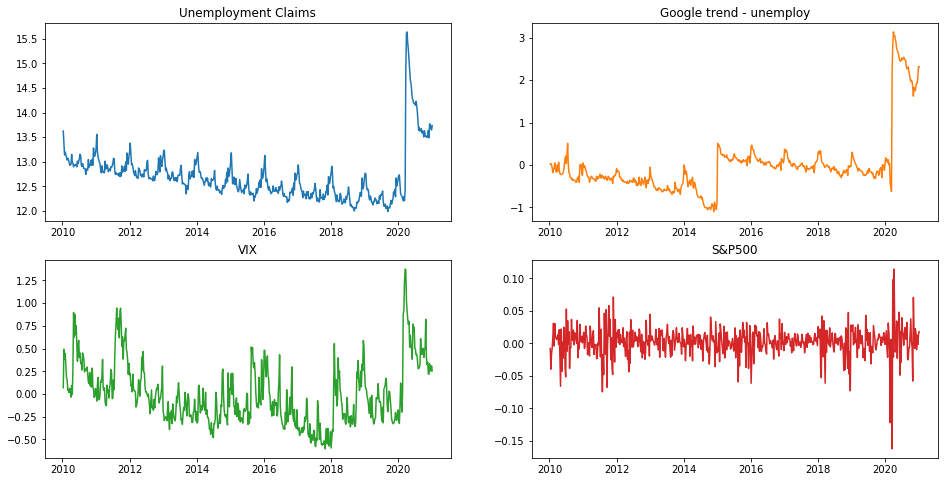

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

## Train / Test Split

To make Bayesian priors comparable across regressors, we need some transformation across regressors. For simplicity, `MixMaxScalar()` is used here. In practice, one can consider standardizing process instead.

In [11]:
# using relatively updated data
# df = df[df['week'] > '2016-01-01'].reset_index(drop=True)
test_size = 12
train_df = df[:-test_size].reset_index(drop=True)
test_df = df[-test_size:].reset_index(drop=True)

scaler = MinMaxScaler()
train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.fit_transform(train_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])
test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']] = scaler.transform(test_df[['claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']])

# Simple DLT Model

In [12]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


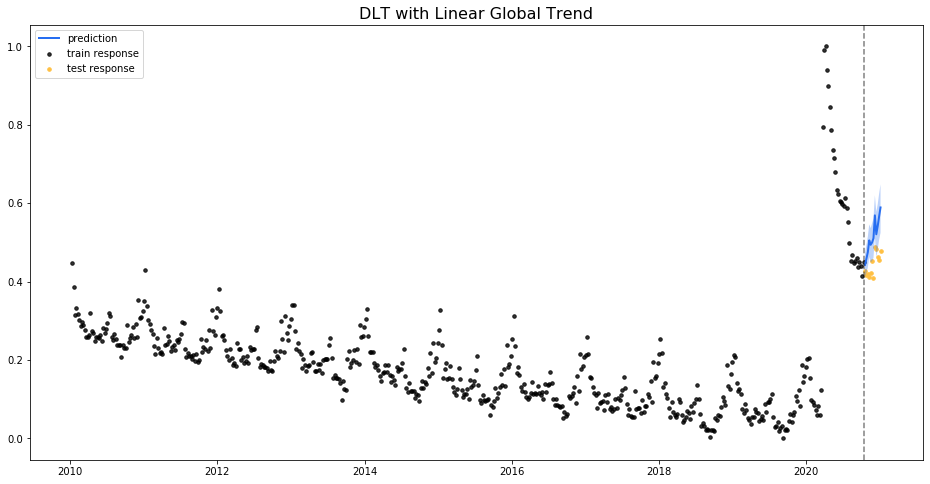

In [13]:
# TODO: some bug on use_orbit_style=True
_ = plot_predicted_data(training_actual_df=train_df, 
                        predicted_df=predicted_df, 
                        date_col=date_col, 
                        actual_col=response_col, 
                        test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Linear Global Trend')

# DLT With Regression

In this session, a regression component is added on top of the `DLT` model.

The regressor columns can be supplied via argument `regressor_col`.  Recall the regression formula in **DLT**:

$$
\hat{y}_t =\mu_t + s_t + r_t \\
r_t = \sum_{j}\beta_j x_{jt} \\
\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Let's use the default (non-informative priors) where $\mu_j = 0$ and $\sigma_j = 1$.

## Regular Regression

In [14]:
dlt_reg = DLT(
    response_col=response_col, 
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500', 'vix'],
    seasonality=52,
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)

dlt_reg.fit(df=train_df)
predicted_df_reg = dlt_reg.predict(test_df, decompose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


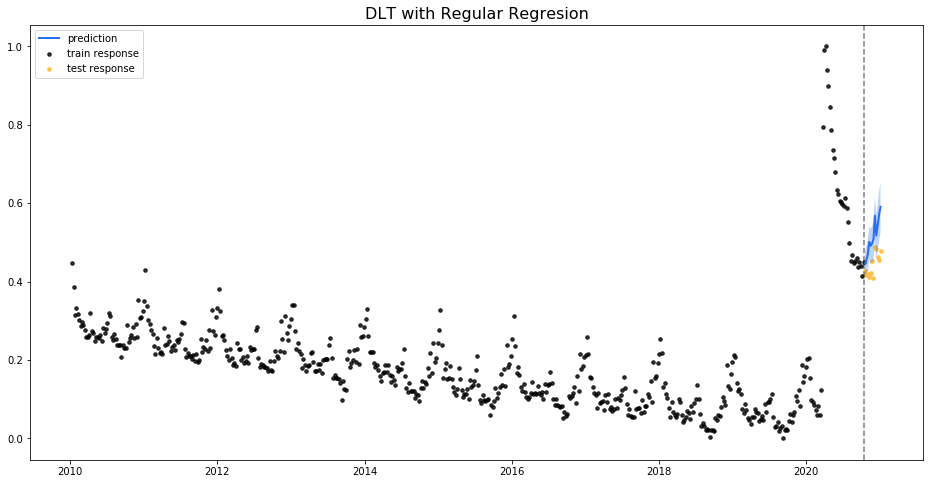

In [15]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regular Regresion')

The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [16]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,0.093305
1,trend.job,Regular,-0.020159
2,sp500,Regular,0.001166
3,vix,Regular,0.006008


# Diagnoses

## Decomposition 

`plot_predicted_components` is the utility to plot each component separately. This is useful when one wants to look into the model prediction results and inspect each component separately.

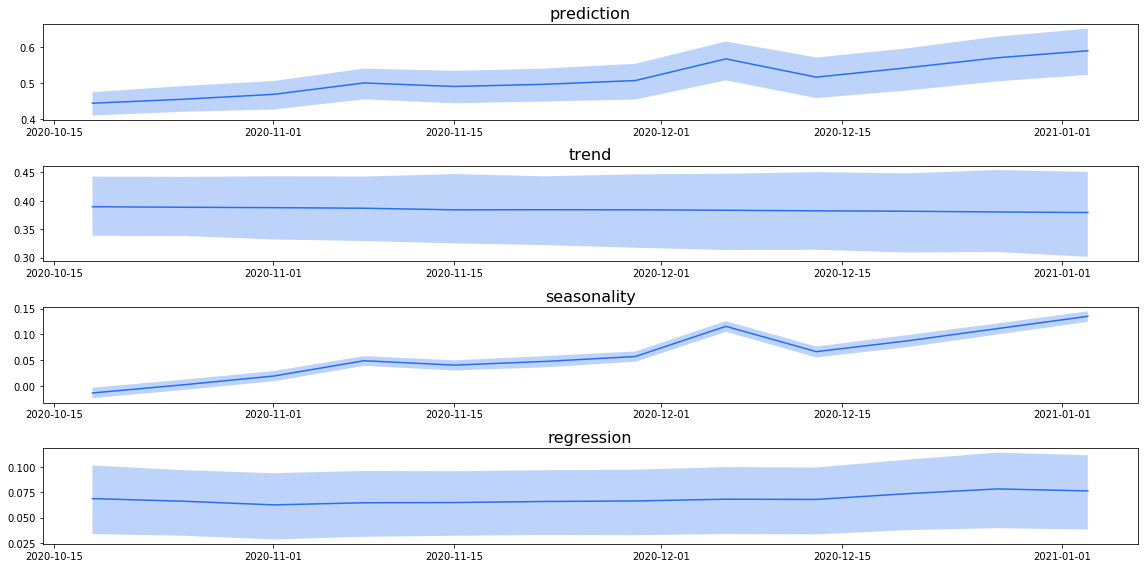

In [17]:
_ = plot_predicted_components(predicted_df_reg, date_col, 
                              use_orbit_style=False,
                              plot_components=['prediction', 'trend', 'seasonality', 'regression'])

## Posterior Diagnostic Visualizations

A few diagnostic plots is recommended for Orbit models. With `version>=1.1.0`,

These plots can be created directly in [Arivz](https://github.com/arviz-devs/arviz) which is a Python package for exploratory analysis of Bayesian models, includes functions for posterior analysis, data storage, model checking, comparison and diagnostics. Two plots can be found below:

1. Trace plot
2. Pair density plot

-

In [18]:
import arviz as az
az.style.use('arviz-darkgrid')

### Trace plot

Trace plot shows the iterations of each paramter over the Markov chian sampling process. Trace plots provide an important tool for assessing mixing of a chain.

In [19]:
ps = dlt_reg.get_posterior_samples(relabel=True, permute=False)
ps.keys()

odict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'trend.unemploy', 'trend.job', 'sp500', 'vix'])

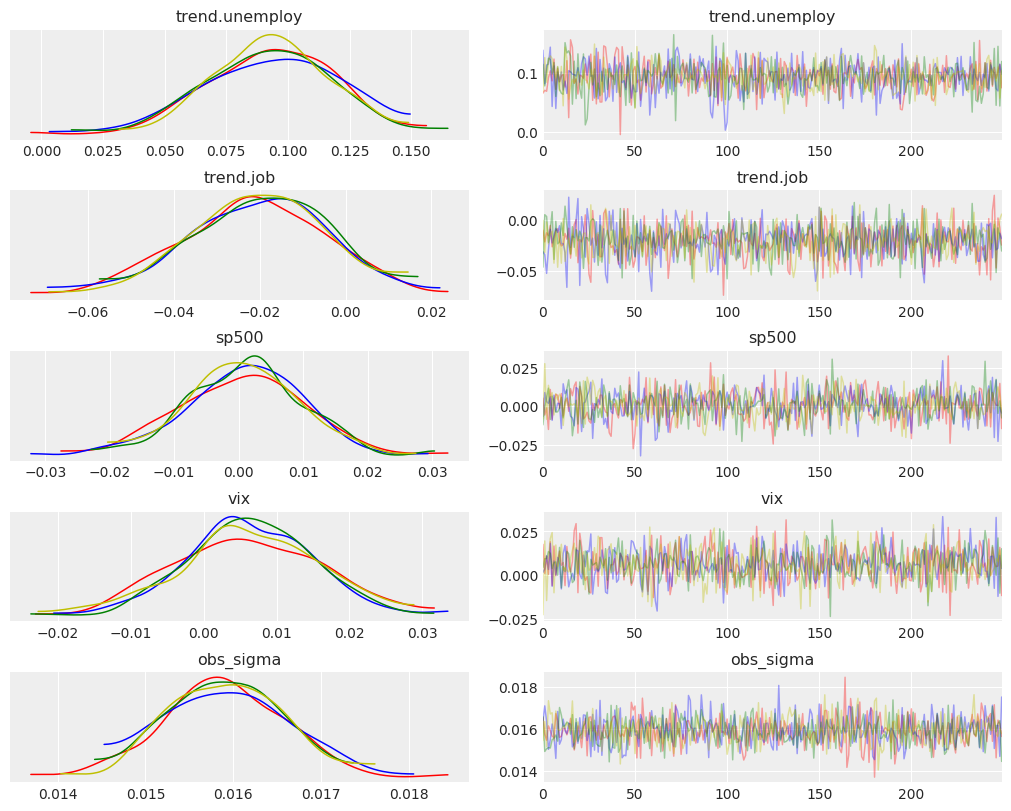

In [20]:
az.plot_trace(
    ps,
    var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
    figsize=(10, 8),
);

### Pair density plot

We can also check the density of samples by pair plot.

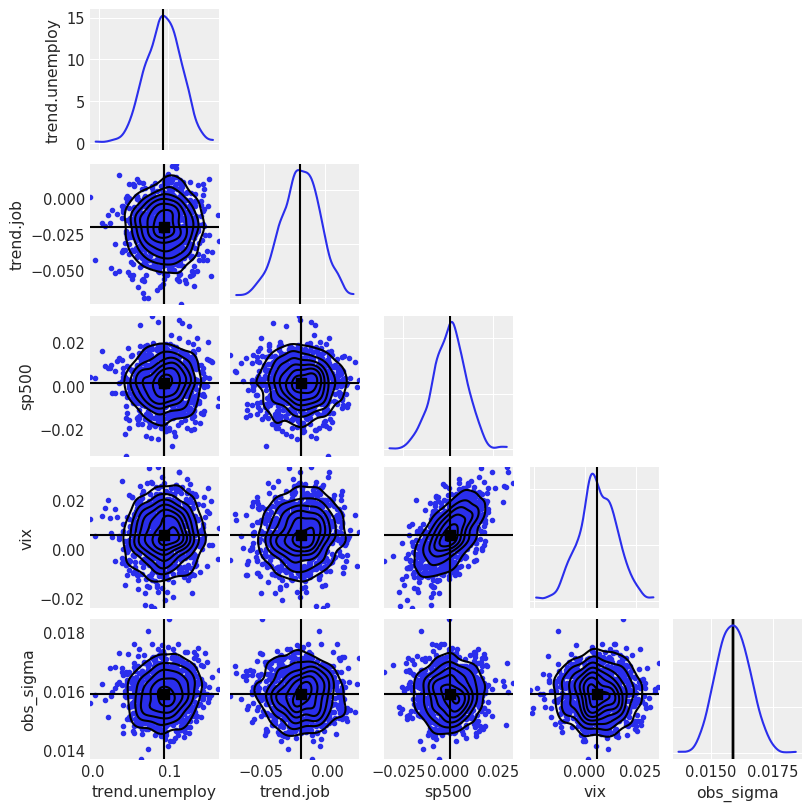

In [21]:
az.plot_pair(
    ps,
    var_names=['trend.unemploy', 'trend.job', 'sp500', 'vix', 'obs_sigma'],
    kind=["scatter", "kde"],
    marginals=True,
    point_estimate="median",
    textsize=10.5,
    figsize=(8,8)
);

# Regression with Informative Priors / Regularized Priors

Due to various reasons, users may obtain further knowledge on some of the regressors or they want to propose different regularization on different regressors. These informative priors basically means to replace the defaults ($\mu$, $\sigma$) mentioned previously. In orbit, this process is done via the arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same length as `regressor_col`.

In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated (`+` sign is used in this case) and upward shock of **SP500** (`-` sign) to be negatively correlated to the outcome. Otherwise, an unbounded coefficient can be used (`=` sign).

Furthermore, regressors such as seach queries may have more direct impact than stock marker indices.  Hence, a smaller $\sigma$ is considered.

In [22]:
dlt_reg_adjust = DLT(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500','vix'],
    regressor_sign=['+','=','-','+'],
    regressor_sigma_prior=[0.3, 0.1, 0.05, 0.1],
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)
dlt_reg_adjust.fit(df=train_df)
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df, decompose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


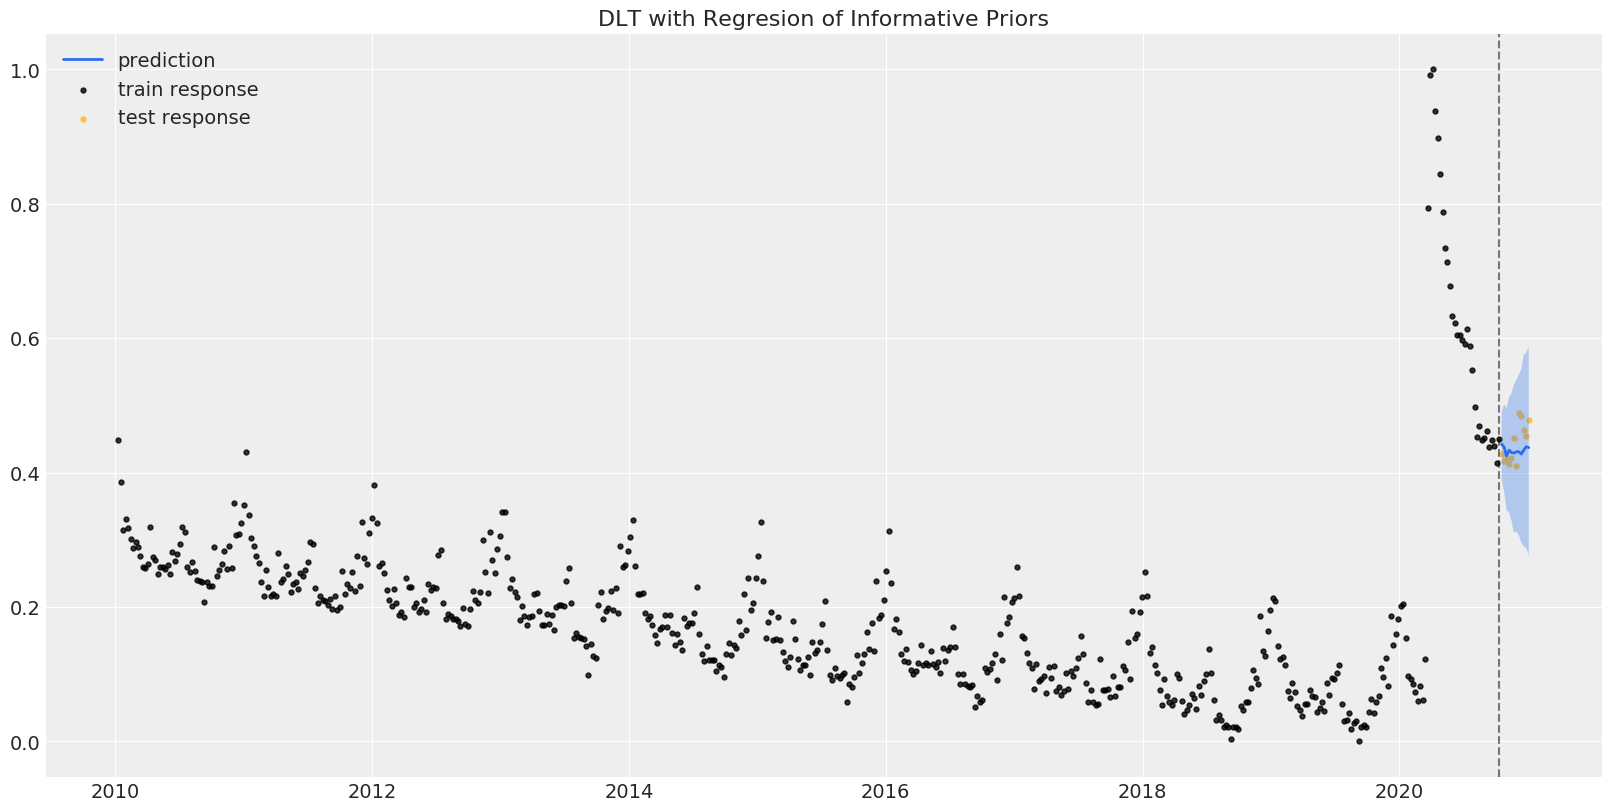

In [23]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df_reg_adjust, 
                        date_col=date_col, actual_col=response_col, test_actual_df=test_df,
                        use_orbit_style=False,
                        title='DLT with Regresion of Informative Priors')

In [24]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.147218
1,vix,Positive,0.007566
2,sp500,Negative,-0.007220
3,trend.job,Regular,-0.006105


In [25]:
naive_mae = mae(predicted_df['prediction'].values, test_df['claims'].values)
reg_mae = mae(predicted_df_reg['prediction'].values, test_df['claims'].values)
reg_adjust_mae = mae(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values)

print("----------------Mean Absolute Error Summary----------------")
print("Naive Model: {:.3f}\nRegression Model: {:.3f}\nRefined Regression Model: {:.3f}".format(
    naive_mae, reg_mae, reg_adjust_mae
))

----------------Mean Absolute Error Summary----------------
Naive Model: 0.070
Regression Model: 0.069
Refined Regression Model: 0.026
